## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2018-19 учебный год

###  Домашнее задание №3. Обработка текстов. Линейная классификация.

Задание выполнил(а): _Билева Анна_

### Общая информация
__Дата выдачи:__ 28.04.2019

__Дедлайн:__ 23:59 12.05.2019

### Оценивание и штрафы

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи
__Стирать условия нельзя!__

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Формат названия файла: homework_03_Фамилия_Имя.ipynb

In [284]:
from collections import Counter
import numpy as np
import nltk
from nltk.stem.snowball import RussianStemmer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

В задании вам предоставлены реальные текстовые данные. 

Необходимо построить алгоритм, который будет по тексту документа определять тип источника:
 - Микроблоги
 - Новости
 - Отзывы
 - Форумы
 - Блоги
 - Видео
 - Мессенджеры

## Часть 1. Работа с текстовыми данными

 ### 1. Исследование данных

[2 балла]

Скачаем данные отсюда:
https://yadi.sk/d/o3cPgFAq5gALiw

In [68]:
D = pd.read_csv('texts_dataset.csv', sep=';', index_col=0, low_memory=False)

In [3]:
D.head()

,Дата,ID сообщения,Заголовок,Текст,Дублей,Тип источника
0,27.04.2019 13:18,1396238,NaN,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",1.0,Микроблоги
1,27.04.2019 13:15,1396239,NaN,Почему Немагия сделала обзор на Тинькова? #нем...,1.0,Микроблоги
2,27.04.2019 13:10,1396248,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",2.0,Новости
3,27.04.2019 13:06,1396243,Forbes назвал самые экстравагантные инвестиции...,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",2.0,Новости
4,27.04.2019 13:03,1396186,Тинькофф Страхование: Не купить полис без подп...,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,1.0,Отзывы


Далее будем использовать лишь поля  "Текст", "Тип источника"

In [69]:
D = D[[ "Текст", "Тип источника"]]

In [5]:
D.head()

,Текст,Тип источника
0,"-Здравствуйте, тинькофф банк\n-Мать твою ебал\...",Микроблоги
1,Почему Немагия сделала обзор на Тинькова? #нем...,Микроблоги
2,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 57 ...",Новости
3,"13:01, 27.04.2019 \n\nПоделиться:\n\n \n 44 ...",Новости
4,Первый отзыв без оценки:&nbsp;\nhttps://www.ba...,Отзывы


In [6]:
for i in D['Тип источника'].unique():
    print (i)

Микроблоги
Новости
Отзывы
Форумы
Блоги
Видео
Мессенджеры
nan


In [7]:
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200206 entries, 0 to 200205
Data columns (total 2 columns):
Текст            199578 non-null object
Тип источника    199993 non-null object
dtypes: object(2)
memory usage: 4.6+ MB


Удалим объекты с пропусками

In [70]:
D.dropna(axis = 0, inplace=True)

#### 1.1 Выведите среднюю длину текстов в каждом классе. Что можно сказать о данных? Что можно сказать о каждом классе?

In [9]:
for text_class in D['Тип источника'].unique():
    print(text_class, D[D['Тип источника'] == text_class]['Текст'].str.len().mean())

Микроблоги 170.06141040462427
Новости 2602.3423206042803
Отзывы 550.4785651967005
Форумы 462.227363457533
Блоги 3490.84946848899
Видео 905.1847899159663
Мессенджеры 943.7823968821045


Видно, что данные имеют отношение к банку Тинькофф, наверное, это датасет с текстами про него; помимо непосредственно текста, в нем присутствует html-разметка, ссылки, даты, esc-последовательности. Скорее всего, это почти не обработанный результат веб-скрапинга. Теперь посмотрим на распределение классов:

In [26]:
D['Тип источника'].value_counts()

Форумы         69136
Отзывы         50432
Новости        38128
Микроблоги     21625
Видео          11900
Блоги           5268
Мессенджеры     3079
Name: Тип источника, dtype: int64

Видно, что данные не очень сбалансированы: встречаются как классы, которых очень много, так и те, которых очень мало. Хотя этого можно было ожидать, исходя из природы классов (очевидно, что самостоятельных больших блогов и образцов текста в них меньше, чем просто комментариев на форумах, например, а из мессенджеров, скорее всего, сложнее достать данные). Рассмотрим каждый класс по отдельности.

In [19]:
microblogs = D[D['Тип источника'] == 'Микроблоги']
print(*np.random.choice(microblogs['Текст'], size=3), sep='\n---\n')

Как устроен "кэшбэк 1%" в банке Олега Тинькоффа:
Тратишь 199 рублей —&gt; кэшбэк 1 рубль. )))
Простое округление вниз. Идеальная маркетинговая наебка.
---
RT @crimerussia: Рекламой Тинькофф Банка для подростков в стиле А.У.Е. заинтересовалась прокуратура
https://t.co/uw2oLoJkOc https://t.co/B84xR9yNo5
---
Объективно говоря, приложение суперудобное. Правда, я в него теперь не захожу, чтобы не видеть свои расходы за август.
RT @4pdaru: Обзор приложения «Тинькофф Банка»: может ли смартфон заменить банковский офис?
https://t.co/40f41kECtY https://t.co/7bSFFmHyPT


Класс "микроблоги" представляет собой результат скрапинга Твиттера. Его особенность заключается в том, что из-за концепции этой соцсети максимальный объем текста составляет 280 символов. Также в образцах присутствуют ретвиты, ники, ссылки на другие твиты. Написаны тексты в этом классе неформальным языком. 

In [25]:
news = D[D['Тип источника'] == 'Новости']
print(*np.random.choice(news['Текст'], size=2), sep='\n---\n')

В&nbsp;России с&nbsp;1&nbsp;июля заработает система биометрического распознавания личности, которая, как предполагается, позволит россиянам значительно сократить частоту визитов в&nbsp;банки и&nbsp;различные госучреждения. Рабочий вариант программы, в&nbsp;понедельник, 19&nbsp;февраля, представил глава «Ростелекома» Александр Айвазов.Открой личикоРазрабатывать единую биометрическую систему идентификации начали примерно полгода назад по&nbsp;заказу Минкомсвязи и&nbsp;Центробанка. Сейчас в&nbsp;«Ростелекоме», который как раз и&nbsp;отвечал за&nbsp;разработку, представили ее&nbsp;рабочую версию&nbsp;— именно в&nbsp;таком виде она начнет функционировать летом 2018-го.«Параллельно с&nbsp;этим “Ростелеком” выбирал оптимальные программные решения, вендоров оборудования и&nbsp;вел переговоры с&nbsp;банками, которые первыми испытают Единую биометрическую систему и&nbsp;будут принимать биометрические данные пользователей»,&nbsp;— приводятся слова главы «Ростелекома» Александра Айвазова на&nbsp;с

Из названия класса можно рассудить, что тексты в нем взяты с новостных сайтов. Соответственно, они имеют бóльшую длину и написаны более формально. Также в них намного больше html-разметки. Иногда встречаются отсылки к источникам информации. Однако помимо этого встречается и мусор (см. образец 2). Наверное, он появился с сайтов вроде telegra.ph (?). Такие образцы отличаются всеми характеристиками спама, например, они короткие, содержат ссылки, написаны немного эмоционально, но не совсем неформально.

In [35]:
reviews = D[D['Тип источника'] == 'Отзывы']
print(*np.random.choice(reviews['Текст'], size=2), sep='\n---\n')

[quote][/quote]
Если бы сюда прикреплялись фото, я бы выложила тут данные такого «сотрудника»
---
Совершенно неудачно выпал валютный платеж, 29 декабря, в последний операционный день банков в России. Следует отметить, что это первый для нашей компании входящий валютный платеж, поэтому вопросов было много. Возникало много вопросов, но больше всего волновало поступление денег. Большим удивлением стало то, что в отличие от других банков, ТБ работал с 4 января, а служба поддержки работу не прекращала вовсе. Благодаря этому, удалось получить валюту на транзитный счет 6 января и раньше начать оформление паспорта сделки. В итоге, удалось оформить паспорт сделки, получить справку о валютных операциях за пару дней. Было заметно, что сотрудники &nbsp;банка могут войти в положение и приложить максимум усилий. Это очень приятно и необычно для нашей системы банков.


Отзывы отличаются короткой длиной, полуформальным языком и наличием разметки. Также в них есть много слов, которые являются оценкой чего-либо: "хорошо", "приятно", "неудачно" и т.д. Ещё можно заметить, что, в отличие от прошлых классов, в них далеко не всегда встречается слово "тинькофф".

In [40]:
forums = D[D['Тип источника'] == 'Форумы']
print(*np.random.choice(forums['Текст'], size=2), sep='\n---\n')

Нет, я говорю лишь о том, что люди заплатили за бренды миллионы, но без поддержки банка тинькофф и их маркетологов, они просрали полимеры.
Это все равно, что Apple была бы продана на пике&nbsp; своей стоимости, а затем потеряла бы доступ к дисплеям самсунг. Компания и двух лет после этого не просуществовала бы.
Это все равно, что во время второй мировой войны убить весь стратегический штаб.
---
XMember писал(а) Сегодня, 00:07:То есть покупка в CAD/THB/CHF и т.д. по любой карте Тинькова в USD пойдёт по курсу МПС (как до октября 2018)?
Тинькофф апрель 2019 покупка в CAD/THB/CHF
VISA $ МПС+0.5%
Mastercard $ МПС


Тексты с форумов написаны формальным/полуформальным языком и обычно не очень длинные. Иногда там есть отсылки к другим сообщениям, ники, даты и разметка.

In [46]:
blogs = D[D['Тип источника'] == 'Блоги']
print(*np.random.choice(blogs['Текст'], size=2), sep='\n---\n')

Вот скажите мне, в чём преимущества и в чём смысл использования таких мутных банков, как Тинькофф? Особенно в наше неспокойное время. И тем более юрлицам, счета которых не страхуются! Вы реально с огнём играете, господа.
---
Все чаще и чаще мои знакомые жалуются, что им заблокировали счёт. Постараемся разобраться, что происходит.
Существует закон о противодействии отмыванию денег (115-ФЗ), согласно которому банки должны препятствовать незаконным операциям клиентам (обналу, незаконному предпринимательству и прочей нелегальщине). Центральный банк очень внимательно смотрит на это при проверках (а банки очень боятся Цб). Поэтому, чтобы не огрести от проверяющих, банкам проще закрыть счёт подозрительному клиенту без объяснений.
ВАЖНО! Многие думают, что банки помогают налоговой отлавливать бизнесов, уходящих от налогов. Это не так (по крайней мере пока). В России существует закон о банковской тайне. И самовольно банк не может передать информацию о ваших счетах в госорганы (иначе у вас есть 

В блогах, в принципе, может быть все, что угодно. Они разнятся как стилем, так и длиной текста. Помимо этого, встречается мусор в виде всяких объявлений.

In [52]:
videos = D[D['Тип источника'] == 'Видео']
print(*np.random.choice(videos['Текст'], size=2), sep='\n---\n')

+Ekaterina Naboychenko Ясно. Просто у меня так было. Забыл заплатить в конце года и в марте арест и инкас на счет прилетели. Значит это уже косяки банка, то что они не разблокирую счет. Тинькоф за пару дней мне разблокировал. Какой у Вас банк?
---
Скандальная акция: iPhone X в России раздают всего за 70 рублей  https://goo.gl/9ssTTm
скачать игры торрент  миссия дарвина  vtb24 online  футбольный клуб барселона  kassir ru  ржд пасс  сотрясение мозга симптомы  пятерочка акции челябинск каталог цены  судебные приставы иркутской области узнать задолженность  работа в щелково свежие вакансии  lady collection  аватария мир где сбываются мечты играть  папка  ермолино полуфабрикаты официальный сайт  видео винди  идти  поликлиника 109 фрунзенского района официальный сайт  15 городская больница выхино официальный сайт  новая больница  девятов  как проверить трафик на теле2  бабилон  голубая ночь поют две девушки  сочи парк отель  cyanogenmod официальный сайт  медика златоуст интернет магазин  xer

Этот класс, видимо, взят из комментариев на youtube. Там, как и везде, встречается всякий мусор, но в основном тексты не длинные и написаны неформальным языком. 

In [58]:
messengers = D[D['Тип источника'] == 'Мессенджеры']
print(*np.random.choice(messengers['Текст'], size=2), sep='\n---\n')

​​🍅 Октябрьский анти-топ банков.🍅
#ХоумКредит #Сбербанк #Запсибкомбанк #Совкомбанк #Солид #Уралсиб #Фондсервисбанк #ВТБ #Тинькофф #ИНГ #Восточный #ЕврокапиталАльянс
Если бы у нас были деньги (плачь) то в эти шарашкины конторы мы бы их не понесли никогда.
Итак, худшие из худших за минувший месяц:
1. Хоум Кредит сдает позиции и запустил пылесос.
2. «Клиентоориентированность» и сотрудники-воры, а также тайный сбор биометрии в Сбербанке.
3. Проблемы с Миром Запсибкомбанка.
4. Навязывание страховки и отказ от досудебного урегулирования в Совкомбанке.
5. В Солид Банке включен пылесос.
6. Уралсиб нарушает закон «О рекламе».
7. Очередные вливания и исчезновение 22 млн рублей из ячейки в Фондсервисбанке.
8. Аттракцион невиданной щедрости и фиктивные премии ВТБ.
9. Сомнительные заявления Тинькофф банка.
10. Технический сбой в ИНГ банке.
11. Незаконный выпуск кредитной карты в банке Восточный.
12. Проблемы в банке Еврокапитал-Альянс.
Встречаемся здесь же через неделю.
@trehlitrovayabanka
---
Банк

Из всех классов, как мне кажется, тексты в этом имеют наименьшее прямое отношение к Тинькофф (точнее, далеко не во всех образцах он является основной темой). Взяты они, скорее всего, из каналов в телеграме, соответственно, большинство из них написаны формальным-полуформальным языком. Длина может быть разной. Отличительные черты: отсутствие любой разметки и дат, иногда встречаются эмодзи.

#### 1.2 Приведите тексты к нижнему регистру и токенезируйте их

используйте word_tokenize из nltk.tokenize

In [71]:
# приведем к нижнему регистру
D['Текст'] = D['Текст'].str.lower()

In [72]:
D['Текст'] = D['Текст'].apply(nltk.word_tokenize)

#### 1.3 Оставьте в каждом документе токены содержащие  только буквы русского или английского алфавита.


In [64]:
def list_only_alpha(s):
    return [w for w in s if w.isalpha()]

In [73]:
D['Текст'] = D['Текст'].apply(list_only_alpha)

#### 1.4 Выведите 20 слов, которые встечаются в наибольшем числе документов. Что можно сказать об этих словах?

In [81]:
count_words = dict()
for i in D['Текст']:
    cur_words = set()
    for word in i:
        if word not in cur_words:
            cur_words.add(word)
            if word not in count_words.keys():
                count_words[word] = 1
            else:
                count_words[word] += 1

In [84]:
count_words = Counter(count_words)

In [91]:
print(*count_words.most_common(20), sep='\n')

('в', 144033)
('и', 136262)
('на', 117638)
('не', 110081)
('тинькофф', 105112)
('с', 100489)
('банк', 93858)
('по', 84583)
('что', 82808)
('а', 71779)
('за', 68298)
('банка', 62513)
('как', 60769)
('это', 59170)
('у', 55321)
('для', 55128)
('так', 50070)
('от', 49675)
('но', 47131)
('к', 45944)


Большинство из этих слов - предлоги, которые встречаются в большом количестве практически в любом тексте. Они не дают никакой информации о датасете, поэтому от них по возможности надо избавиться. Также часто встречаются слова-индикаторы того, что этот датасет посвящен Тинькофф-банку.

#### 1.5 Выведите 20 слов, которые встечаются в наименьшем числе документов 

In [92]:
print(*count_words.most_common()[len(count_words)-20:], sep='\n')

('вардер', 1)
('охеренный', 1)
('фейсу', 1)
('jagger', 1)
('психую', 1)
('устанлвлено', 1)
('вылазящий', 1)
('кэшбжком', 1)
('повалится', 1)
('netesov', 1)
('отреклось', 1)
('сварганили', 1)
('кредитчику', 1)
('наличгыми', 1)
('выписного', 1)
('pandeglol', 1)
('пэйпассу', 1)
('заказывый', 1)
('советсткую', 1)
('сверкало', 1)


В основном это слова, написанные с ошибками. Также тут есть слова, которые означают что-то непонятное/слова, которые редко употребляются/просто не особо имеющие отношение к тематике текстов.

### 2. Подготовка данных

[3 балла]

####  2.1 Разделите выборку на обучающую и тестовую в соотношении 70:30

In [98]:
D['Текст'] = D['Текст'].apply(' '.join)
df_train, df_test = train_test_split(D, test_size=0.3, random_state=42)

#### 2.2 Обучите BOW векторы на обучающей выборке и примените преобразование к обучающей и тестовой

In [101]:
bow_vec = CountVectorizer()
bow_train = bow_vec.fit_transform(df_train['Текст'].values)
bow_test = bow_vec.transform(df_test['Текст'].values)

#### 2.3 Обучите TFIDF векторы на обучающей выборке и примените преобразование к тестовой

In [102]:
tfidf_vec = TfidfVectorizer()
tfidf_train = tfidf_vec.fit_transform(df_train['Текст'].values)
tfidf_test = tfidf_vec.transform(df_test['Текст'].values)

#### 2.4 Примените стемминг к текстам обучающей и тестовой выборки. Обучите TFIDF векторы на полученных данных.

In [108]:
stemmer = RussianStemmer()


def stem_a_string(s):
    return ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(s)])    

In [109]:
stemmed_train = df_train['Текст'].apply(stem_a_string)
stemmed_test = df_test['Текст'].apply(stem_a_string)
new_tfidf = TfidfVectorizer()
tfidf_stemmed_train = new_tfidf.fit_transform(stemmed_train)
tfidf_stemmed_test = new_tfidf.transform(stemmed_test)

#### 2.5 Сравните размеры полученных матриц

In [112]:
print(f'Train set, TF-IDF: stemmed - {tfidf_stemmed_train.shape}, not stemmed - {tfidf_train.shape}, BOW: {bow_train.shape}',
f'Test set, TF-IDF: stemmed - {tfidf_stemmed_test.shape}, not stemmed - {tfidf_test.shape}, BOW: {bow_test.shape}', 
      sep='\n')

Train set, TF-IDF: stemmed - (139697, 123887), not stemmed - (139697, 278913), BOW: (139697, 278913)
Test set, TF-IDF: stemmed - (59871, 123887), not stemmed - (59871, 278913), BOW: (59871, 278913)


Таким образом, стемминг помог сократить размеры матриц больше чем в два раза.

### 3. Обучение модели и оценка результатов

[2 балла]

#### 3.1 Обучите логистическую регрессию SGDClassifier на данных, полученных в пунктах 2.2, 2.3 и 2.4.
#### Оцените качество на отложенной выборке по метрике accuracy

In [124]:
sgd_bow = SGDClassifier(loss='log', random_state=42, max_iter=100, tol=1e-3)
sgd_bow.fit(bow_train, df_train['Тип источника'])
predict_bow = sgd_bow.predict(bow_test)
accuracy_score(df_test['Тип источника'], predict_bow)

0.8406741160161013

In [125]:
sgd_tfidf = SGDClassifier(loss='log', random_state=42, max_iter=100, tol=1e-3)
sgd_tfidf.fit(tfidf_train, df_train['Тип источника'])
predict_tfidf = sgd_tfidf.predict(tfidf_test)
accuracy_score(df_test['Тип источника'], predict_tfidf)

0.7991181039234354

In [126]:
sgd_stemmed_tfidf = SGDClassifier(loss='log', random_state=42, max_iter=100, tol=1e-3)
sgd_stemmed_tfidf.fit(tfidf_stemmed_train, df_train['Тип источника'])
predict_stemmed_tfidf = sgd_stemmed_tfidf.predict(tfidf_stemmed_test)
accuracy_score(df_test['Тип источника'], predict_stemmed_tfidf)

0.7928212323161464

#### 3.2 Какой алгоритм показал наилучшее качество классификации? Как это можно объяснить?

Лучшее качество показал SGD, обученный на BoW. Видимо, в этой задаче вес слова в отдельном документе (т.е. TF) не имеет особого значения, поэтому BoW, учитывающий только встречаемость слова в разных документах, выиграл. Это объясняется тем, что у классов в этом датасете почти нет своей специфической лексики, что неудивительно, учитывая природу данных.

#### 3.3 Выведите несколько документов из тестовой выборки, на которых были допущены ошибки. Что можно о них сказать?

In [185]:
wrong_answers_df = df_test[df_test['Тип источника'] != predict_bow]
wrong_answers_predict = predict_bow[predict_bow != df_test['Тип источника']]
wrong_answers_df['Ответ модели'] = wrong_answers_predict
print(*np.array(wrong_answers_df.sample(n=10)), sep='\n')

['сбербанк последний банк с чьими картами за границу надо ездить недавно ездили в грецию та же беда была с картами от сбера переводы на другие карты и оплату блокировали типа подозрительные операции мы выполняем проверку хорошо с собой были карты тинькофф не сочтите за рекламу с ними проблем никаких небыло всю поездку'
 'Видео' 'Форумы']
['переводил деньги на сбер в другой регион нужно было сообщение в переводе написать то попросил коллегу отправить комиссия блин внутри банка я коллеге с тинькофф вернул и без всяких комиссий зачем ваще сбером пользоваться я хз'
 'Микроблоги' 'Форумы']
['ленту новостей как включить мне нравилось хоть чем то отличается от остальных банков'
 'Отзывы' 'Форумы']
['ксения собчак vs олег тиньков я потерял миллиард долларов грамматической ошибкиксения собчак расспросила владельца об инвесторах о выколачивании долгов и о том наденет ли он галстук на встречу с путиным posted by maks sunray master on май'
 'Блоги' 'Форумы']
['в цб и правление тинькофф претензия н

/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


По многим текстам отсюда видно, что они носят довольно общий характер и могли быть взяты из любого источника, откуда брались данные. Часто путаются форумы и отзывы, потому что эти классы похожи по содержанию в принципе.

#### 3.4 Постройте матрицу ошибок. Проанализируйте ее.

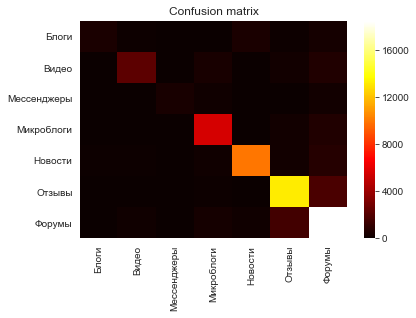

In [289]:
sns.heatmap(confusion_matrix(df_test['Тип источника'], predict_bow, labels=sgd_bow.classes_), 
            xticklabels=sgd_bow.classes_, yticklabels=sgd_bow.classes_, cmap='hot')
plt.title('Confusion matrix')
plt.show()

In [199]:
pd.Series(predict_bow).value_counts()

Форумы         22811
Отзывы         15707
Новости        10751
Микроблоги      6806
Видео           2724
Блоги            604
Мессенджеры      468
dtype: int64

In [201]:
df_test['Тип источника'].value_counts()

Форумы         20732
Отзывы         15248
Новости        11380
Микроблоги      6464
Видео           3561
Блоги           1553
Мессенджеры      933
Name: Тип источника, dtype: int64

Видно, что чем больше в данных экземпляра класса, тем лучше он предсказывается. Видимо, модель почти не учитывает дисбаланс классов, но на accuracy это сказалось не так сильно, потому что блоги и мессенджеры составляют лишь малую часть датасета.

## Часть 2. Логистическая регрессия.
[3 балла]

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [389]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.
​
Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [390]:
train['price'] = (train['price_range'] != 0).astype(int)

In [391]:
y_train = train['price']
train = train.drop(['price', 'price_range'], axis=1)

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [392]:
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size=0.3, random_state=42)

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [393]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?
Не забывайте, что метод predict_proba вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [394]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)
accuracy_score(y_test, predict)

/Users/stppnwlf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9866666666666667

In [395]:
predict_first = [i[1] for i in lr.predict_proba(X_test)]
roc_auc_score(y_test, predict_first)

0.999321523916282

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

In [265]:
b = lr.intercept_ + np.dot(lr.coef_, X_test.T) 

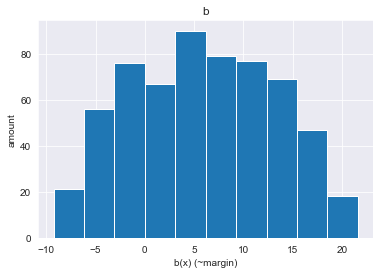

In [292]:
plt.hist(b.T)
plt.title('b')
plt.ylabel('amount')
plt.xlabel('b(x) (~margin)')
plt.show()

b(x) возвращает отступ от границы классов (со смещением). Соответственно, чем больше отступ по модулю, тем увереннее мы можем говорить о принадлежности того или иного элемента классу 0 или 1. Если правильно отнормировать (использовать сигмоиду), то можно привести это к вероятностям классов (что вытекает из смысла отступа).

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

In [268]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

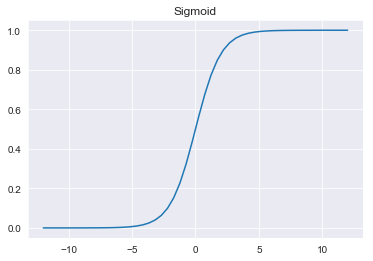

In [287]:
sns.set_style('darkgrid')
x_values = np.linspace(-12, 12)
y_values = sigmoid(x_values)
plt.plot(x_values, y_values)
plt.title('Sigmoid')
plt.show()

Сигмоида принимает значения от 0 до 1, на минус бесконечности стремится к 0, на плюс бесконечности к 1. Соответственно, ее можно использовать, чтобы приводить какие-либо значения к вероятности.

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [283]:
np.allclose(predict_first, sigmoid(b))

True

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

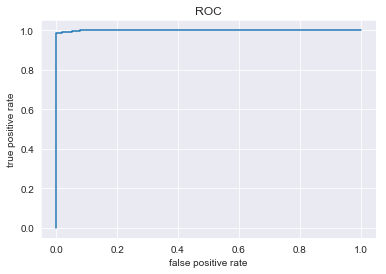

In [288]:
fpr, tpr, _ = roc_curve(y_test, predict_first)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

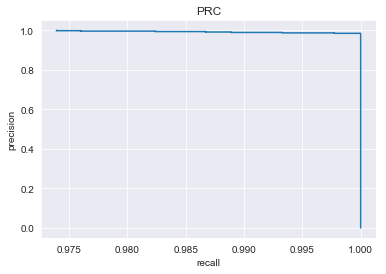

In [291]:
rec, prec, _ = precision_recall_curve(y_test, predict_first)
plt.plot(rec, prec)
plt.title('PRC')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

### 4. Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$



Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.
Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.
Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково.

В качестве критерия останова необходимо использовать (одновременно):

- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В loss_history необходимо сохранять вычисленное на каждой итерации значение функции потерь.

In [410]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        np.random.seed(2989298557)
        self.w = np.random.rand(X.shape[1] + 1)
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        cur_prec = 1
        cur_iter = 0
        while cur_iter < self.max_iter and cur_prec > self.tolerance:
            self.loss_history.append(self.calc_loss(X, y))
            weights = self.w.copy()
            self.w = self.w - self.alpha * self.calc_gradient(X, y)
            cur_iter += 1
            cur_prec = np.abs(np.linalg.norm(self.w - weights))
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        res = np.asarray((1 - 1 / (1 + np.exp(-self.w[0] - np.dot(self.w[1:], X.T))), 
                1 / (1 + np.exp(-self.w[0] - np.dot(self.w[1:], X.T)))))
        ans = []
        for i in range(res.shape[1]):
            ans.append((res[0][i], res[1][i]))
        return ans
    
    
    def predict(self, X):
        """
        X: np.array of shape(l, d)
        ---
        output: np.array of shape (l, 1):
        1 if predict_proba(x)[1] >= 0.5
        0 otherwise
        """
        if self.w is None:
            raise Exception('Not trained yet')
        return [1 if y_pred[1] >= 0.5 else 0 for y_pred in self.predict_proba(X)]
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        return -(np.dot(X.T, y) / (1 + np.exp(np.dot(y.T, np.dot(self.w, X.T))))) + self.lambda_2 * self.w

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return np.sum(np.log(1 + np.exp(-y * np.dot(X, self.w)))) / y.shape[0] + self.lambda_2 / 2 * np.linalg.norm(
            self.w)

- Примените логистическую регресиию на той же выборке.
- Посчитайте качество по тем же метрикам.
- Визуализируйте изменение значений функции потерь от номера итераций.

In [411]:
custom_lr = LogReg()
custom_lr.fit(X_train, y_train)
predict = custom_lr.predict(X_test)
accuracy_score(y_test, predict)

0.6333333333333333

In [416]:
predict_first = [i[1] for i in custom_lr.predict_proba(X_test)]
roc_auc_score(y_test, predict_first)

0.6682841929821973

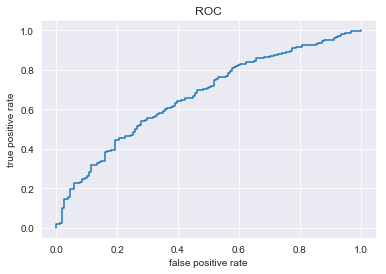

In [417]:
fpr, tpr, _ = roc_curve(y_test, predict_first)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

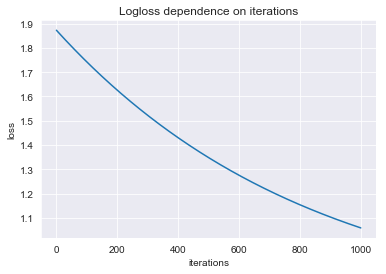

In [420]:
plt.plot(custom_lr.loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title('Logloss dependence on iterations')
plt.show()

### 5. Бонусное задание 2. 

[0.002 бонусных балла]

Напишите свой любимый текстовый (у нас же домашнее задание про тексты, ощущаете иронию) мем или анекдот

I've decided that from January 1st, I'm only going to watch things that are 1080p and above.
It's my new year's resolution.